In [93]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

# Modeling and Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [94]:
df = pd.read_excel('temperature_data.xlsx')


In [95]:
df.head(20)

,Date,Time,Temp Conventinal solar panel,Temp Pure Sisal,Temp Sisal + Jute,Temp Coated sisal,Temp Coated Sisal + Jute
0,02.01.23,09:00:00,88.6,87.9,88.9,90.0,90.8
1,02.01.23,10:00:00,91.5,90.9,91.9,88.4,90.4
2,02.01.23,11:00:00,99.6,96.2,99.2,105.5,105.4
3,02.01.23,12:00:00,95.8,96.4,94.7,95.9,98.1
4,02.01.23,13:00:00,102.5,99.0,100.7,99.7,101.8
5,02.01.23,14:00:00,98.8,97.8,98.2,97.8,99.7
6,02.01.23,15:00:00,94.6,96.3,95.7,96.5,98.9
7,02.01.23,16:00:00,77.9,78.9,77.7,78.1,77.7
8,02.01.23,17:00:00,76.2,75.8,76.9,76.8,77.3
9,03.01.23,09:00:00,86.6,85.1,85.4,86.9,87.1


In [96]:
df.columns=df.columns.str.strip()

In [97]:
df.columns 

Index(['Date', 'Time', 'Temp Conventinal solar panel', 'Temp Pure Sisal',
       'Temp Sisal + Jute', 'Temp Coated sisal', 'Temp Coated Sisal + Jute'],
      dtype='object')

In [98]:
df['Date_Time'] = df['Date'] + ' ' + df['Time'].astype('str')

In [99]:
df['Date_Time'] = pd.to_datetime(df['Date_Time'], yearfirst=True, dayfirst=False, format='%d.%m.%y %H:%M:%S')



In [100]:
df.drop(['Date','Time'],inplace=True,axis=1)

In [101]:
df['Date_Time'].iloc[0].month

1

In [102]:
df.size

378

In [103]:
df = df.set_index('Date_Time')
df = df.asfreq(freq ='8H')
df = df.sort_index()

In [104]:
print(f'Number of rows with missing values: {df.isnull().any(axis=1).mean()}')


Number of rows with missing values: 0.3


In [105]:
df = df.resample('8H').mean().ffill()

Train dates : 2023-01-02 08:00:00 --- 2023-01-07 16:00:00  (n=17)
Test dates  : 2023-01-08 00:00:00 --- 2023-01-08 16:00:00  (n=3)


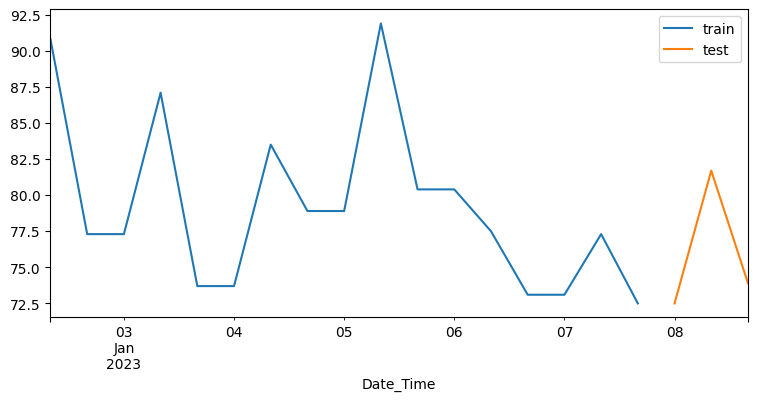

In [106]:
# Split data into train-test
# ==============================================================================
steps = 3
data_train = df[:-steps]
data_test  = df[-steps:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

fig, ax=plt.subplots(figsize=(9, 4))
data_train['Temp Coated Sisal + Jute'].plot(ax=ax, label='train')
data_test['Temp Coated Sisal + Jute'].plot(ax=ax, label='test')
ax.legend();

In [107]:
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123,n_estimators= 100,
              max_depth=  10),
                lags = 4
             )

forecaster.fit(y=data_train['Temp Coated Sisal + Jute'])

In [108]:
steps = 3
predictions = forecaster.predict(steps=steps)
predictions

2023-01-08 00:00:00    80.311
2023-01-08 08:00:00    82.524
2023-01-08 16:00:00    78.477
Freq: 8H, Name: pred, dtype: float64

In [109]:
df.columns

Index(['Temp Conventinal solar panel', 'Temp Pure Sisal', 'Temp Sisal + Jute',
       'Temp Coated sisal', 'Temp Coated Sisal + Jute'],
      dtype='object')

In [110]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['Temp Coated Sisal + Jute'],
                y_pred = predictions
            )

print(f"MSE Error of Temp Coated Sisal + Jute' : {error_mse}")

MSE Error of Temp Coated Sisal + Jute' : 27.54654199999922


Train dates : 2023-01-02 08:00:00 --- 2023-01-07 16:00:00  (n=17)
Test dates  : 2023-01-08 00:00:00 --- 2023-01-08 16:00:00  (n=3)


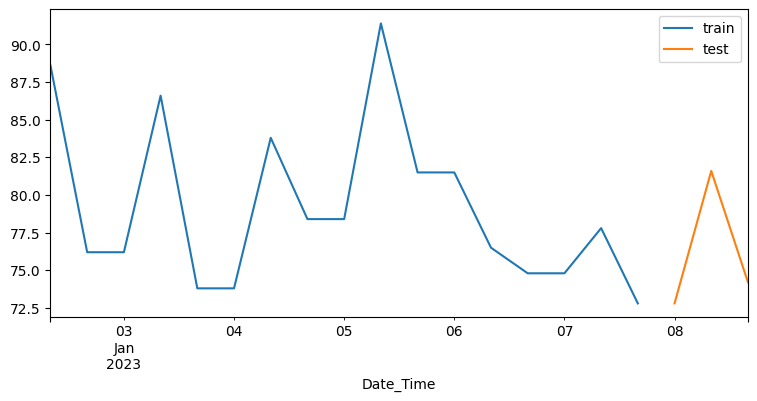

In [111]:
# Split data into train-test
# ==============================================================================
steps = 3
data_train = df[:-steps]
data_test  = df[-steps:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

fig, ax=plt.subplots(figsize=(9, 4))
data_train['Temp Conventinal solar panel'].plot(ax=ax, label='train')
data_test['Temp Conventinal solar panel'].plot(ax=ax, label='test')
ax.legend();

In [112]:
def temperature_prediction(df,column_predict,steps):
    df = df.rename(columns={column_predict: 'y'})
    forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123,n_estimators= 100,
              max_depth=  10),
                lags = 4
             )

    forecaster.fit(y=df['y'])
    predictions = forecaster.predict(steps=steps)
    return predictions

    

In [113]:
df.columns

Index(['Temp Conventinal solar panel', 'Temp Pure Sisal', 'Temp Sisal + Jute',
       'Temp Coated sisal', 'Temp Coated Sisal + Jute'],
      dtype='object')

In [125]:
predictions=temperature_prediction(df,'Temp Coated Sisal + Jute',15)

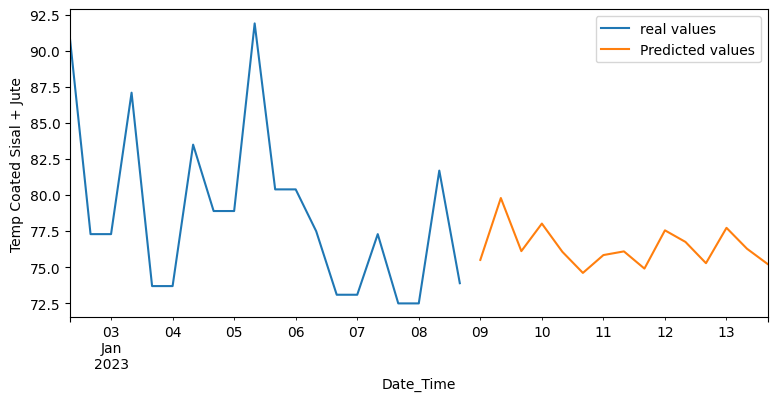

In [126]:


fig, ax=plt.subplots(figsize=(9, 4))
df['Temp Coated Sisal + Jute'].plot(ax=ax, label='real values')
predictions.plot(ax=ax, label='Predicted values')
plt.ylabel('Temp Coated Sisal + Jute')
ax.legend();